# <font color='#1a5276'> <b> <center> Initialization techniques </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4)
5. [Model and training function](#5)
6. [Testing different initialization techniques](#6) <br>
    6.1. [Default initialization](#6.1) <br>
    6.2. [Xavier initialization](#6.2) <br>
    6.3. [He initialization](#6.3) <br>
    6.4. [Comparing results](#6.4) <br>
7. [Annex](#annex) <br>
    A. [Code clarifications](#A) <br>
    B. [Initialization techniques in PyTorch](#B) <br>
8. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In deep learning, the choice of weight initialization can significantly impact the performance and convergence of neural networks. Proper initialization helps prevent issues like vanishing or exploding gradients, leading to faster training and improved results.

This notebook explores different weight initialization techniques, including Xavier and He initialization, demonstrating how they affect the performance of neural networks. By the end, you'll see how selecting the right initialization can improve training stability and model accuracy.

We will explore the following techniques for initialization:

- Default initialization (Kaiming Uniform for linear layers)

- Xavier Initialization

- He initialization

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [94]:
torch.set_printoptions(
    precision=3,      # Set the number of decimal places to print
)

In [3]:
torch.manual_seed(0)

<a name="3"></a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

In [48]:
# plot metrics
def plot_training_metrics(metrics, metric_name, title, xlabel, ylabel):
    """
    Plot training metrics for multiple configurations with custom colors and bold formatting.

    Parameters:
    - metrics (dict): A dictionary where keys are labels (e.g., 'Xavier', 'Default', 'He') 
      and values are lists of metric values (e.g., training loss over iterations).
    - metric_name (str): The name of the metric being plotted (e.g., 'training_loss').
    - title (str): The title of the plot.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.
    """
    # Plot each set of values with its label
    for label, values in metrics.items():
        plt.plot(values, label=label)  
    
    # Customize axes and title with colors and bold formatting
    plt.xlabel(xlabel, fontsize=12, fontweight='bold', color='purple')  # X-axis label
    plt.ylabel(ylabel, fontsize=12, fontweight='bold', color='purple')  # Y-axis label
    plt.title(title, fontsize=14, fontweight='bold', color='darkred')  # Title
    
    # Add legend and show the plot
    plt.legend()
    plt.show()


<a name="4"></a>
## <font color='blue'> <b> 4. Data </b> </font>

We will use the MNIST dataset.

In [5]:
# Create the train dataset
train_dataset = dsets.MNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())

In [6]:
# Create the validation dataset
validation_dataset = dsets.MNIST(root='data/', train=False, download=True, transform=transforms.ToTensor())

In [7]:
# Create Dataloader for both train dataset and validation dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a name="5"></a>
## <font color='blue'> <b> 5. Model and training function </b> </font>

In [16]:
input_dim = 28 * 28 # 28x28 greyscale images
output_dim = 10 # 10 classes
layers = [input_dim, 100, 10, 100, 10, 100, output_dim]
epochs = 15
learning_rate = 0.01

### Model definition

In [12]:
class Net(nn.Module):
    # Constructor
    def __init__(self, Layers, init_method=None):
        """
        Parameters:
        - Layers: list of integers defining the layer sizes.
        - init_method: a callable function for weight initialization (e.g., torch.nn.init.xavier_uniform_).
                       If None, uses PyTorch's default initialization.
        """
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            
            # Apply the custom initialization method if provided
            if init_method is not None:
                init_method(linear.weight)
            
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x


### Training loop

In [20]:
def train(model, criterion, train_loader, validation_loader, optimizer, input_size=input_size, epochs=100):
    """
    Train a given model on a dataset and validate it periodically.

    Parameters:
    - model: The neural network model to be trained.
    - criterion: The loss function used for optimization.
    - train_loader: DataLoader for the training dataset, providing batches of data.
    - validation_loader: DataLoader for the validation dataset.
    - optimizer: The optimizer used to update the model's weights.
    - input_size: input size of the image (28*28 for mnist)
    - epochs (int): Number of epochs (iterations over the entire dataset).

    Returns:
    - loss_accuracy (dict): A dictionary containing:
        - 'training_loss': A list of training loss values for each batch.
        - 'validation_loss': A list of validation loss values at the end of each epoch.
        - 'training_accuracy': A list of training accuracy values at the end of each epoch.
        - 'validation_accuracy': A list of validation accuracy values at the end of each epoch.
    """
    
    loss_accuracy = {
        'training_loss': [],
        'validation_loss': [],
        'training_accuracy': [],
        'validation_accuracy': []
    }

    for epoch in range(epochs):  # Loop over each epoch
        # Track training metrics
        correct_train = 0
        total_train = 0

        # i: index of the batch, x: image, y:label
        for i, (x, y) in enumerate(train_loader):  # Loop over training batches
            optimizer.zero_grad()  # Reset gradients for the optimizer
            z = model(x.view(-1, input_size))  # Flatten input and forward pass through the model
            loss = criterion(z, y)  # Compute the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update model weights using the optimizer

            loss_accuracy['training_loss'].append(loss.data.item())  # Record the loss value

            # Calculate training accuracy
            _, label = torch.max(z, 1)  # Get predicted labels
            correct_train += (label == y).sum().item()  # Count correct predictions
            total_train += y.size(0)  # Total number of samples in the batch

        training_accuracy = 100 * (correct_train / total_train)  # Calculate training accuracy
        loss_accuracy['training_accuracy'].append(training_accuracy)  # Record training accuracy

        # Track validation metrics
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        for x, y in validation_loader:  # Loop over validation batches
            yhat = model(x.view(-1, input_size))  # Flatten input and forward pass through the model
            loss = criterion(yhat, y)  # Compute validation loss
            val_loss += loss.item()  # Sum validation loss

            _, label = torch.max(yhat, 1)  # Get the predicted class label
            correct_val += (label == y).sum().item()  # Count correct predictions
            total_val += y.size(0)  # Total number of samples in the batch

        validation_accuracy = 100 * (correct_val / total_val)  # Calculate validation accuracy
        val_loss /= len(validation_loader)  # Average validation loss

        loss_accuracy['validation_accuracy'].append(validation_accuracy)  # Record validation accuracy
        loss_accuracy['validation_loss'].append(val_loss)  # Record validation loss

    return loss_accuracy  # Return the dictionary with all metrics


### Criterion

In [21]:
# Define criterion function
criterion = nn.CrossEntropyLoss()

<a name="6"></a>
## <font color='blue'> <b> 6. Testing different initialization techniques </b> </font>

<a name="6.1"></a>
### <font color='#2874a6'> <b> 6.1. Default initialization </b> </font>

In [22]:
model = Net(layers)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
training_results_default = train(model, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

<a name="6.2"></a>
### <font color='#2874a6'> <b> 6.2. Xavier initialization </b> </font>

In [24]:
model_Xavier = Net(layers, init_method=torch.nn.init.xavier_uniform_)
optimizer_Xavier = torch.optim.SGD(model_Xavier.parameters(), lr=learning_rate)
training_results_Xavier = train(model_Xavier, criterion, train_loader, validation_loader, 
                                optimizer_Xavier, epochs=epochs)

<a name="6.3"></a>
### <font color='#2874a6'> <b> 6.3. He initialization </b> </font>

In [25]:
model_he = Net(layers, init_method = torch.nn.init.kaiming_uniform_)
optimizer_he = torch.optim.SGD(model_he.parameters(), lr=learning_rate)
training_results_he = train(model_he, criterion, train_loader, validation_loader, optimizer_he, epochs=epochs)

<a name="6.4"></a>
### <font color='#2874a6'> <b> 6.4. Comparing results </b> </font>

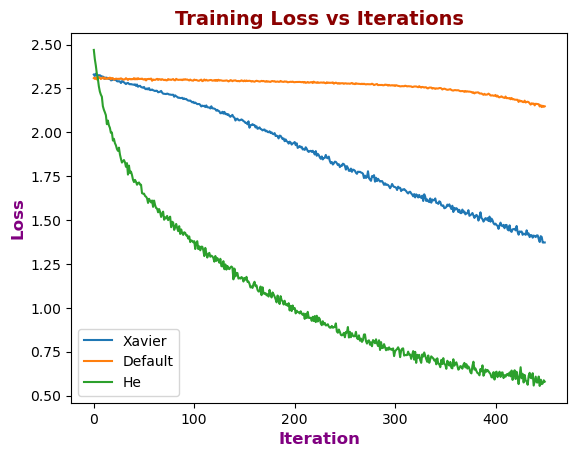

In [49]:
# Prepare the metrics dictionary for the training losses
metrics = {
    'Xavier': training_results_Xavier['training_loss'],
    'Default': training_results_default['training_loss'],
    'He': training_results_he['training_loss']
}

# Plot training loss
plot_training_metrics(
    metrics=metrics,
    metric_name='training_loss',
    title='Training Loss vs Iterations',
    xlabel='Iteration',
    ylabel='Loss'
)

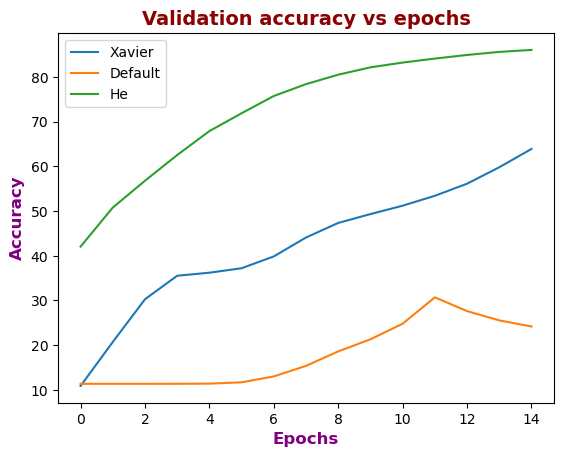

In [50]:
# Prepare the metrics dictionary for the validation accuracy
metrics = {
    'Xavier': training_results_Xavier['validation_accuracy'],
    'Default': training_results_default['validation_accuracy'],
    'He': training_results_he['validation_accuracy']
}

# Plot training loss
plot_training_metrics(
    metrics=metrics,
    metric_name='validation_accuracy',
    title='Validation accuracy vs epochs',
    xlabel='Epochs',
    ylabel='Accuracy'
)

We can see that the initialization method has a significant impact on the performance of our model. In this example, we achieve the best results using He initialization.

<a name="annex"></a>
## <font color='blue'> <b> Annex </b> </font>

<a name="A"></a>
### <font color='#2874a6'> <b> A. Code clarifications </b> </font>

###  Code 1

Input and output sizes for a deep net.

In [51]:
Layers = [64, 128, 256, 10]

for input_size, output_size in zip(Layers, Layers[1:]):
    print(f"Connecting layer of size {input_size} to layer of size {output_size}")

Connecting layer of size 64 to layer of size 128
Connecting layer of size 128 to layer of size 256
Connecting layer of size 256 to layer of size 10


### Code 2

Looping data in a trainloader.

In [61]:
train_loader_example = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)

In [65]:
z = 0
for i,(x, y) in enumerate(train_loader_example):
    print(f"Index of the batch: {i}")
    print(f"Feature: {x}")
    print(f"Label: {y}\n")
    if z == 2:
        break
    z+=1

Index of the batch: 0
Feature: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
Label: tensor([0, 7])

Index of the batch: 1
Feature: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 

We print 3 batches, where each batch has a size of 2. Thus, for each one, we have 2 values of x and 2 values of y.

<a name="B"></a>
### <font color='#2874a6'> <b> B. Initialization techniques in PyTorch </b> </font>

### Uniform

In [98]:
w = torch.rand(3, 5)
print(f"Before:\n {w}")
nn.init.uniform_(w)
print(f"After:\n {w}")

Before:
 tensor([[0.282, 0.926, 0.725, 0.329, 0.797],
        [0.420, 0.475, 0.571, 0.996, 0.590],
        [0.720, 0.280, 0.579, 0.366, 0.665]])
After:
 tensor([[0.701, 0.330, 0.209, 0.827, 0.116],
        [0.030, 0.573, 0.086, 0.994, 0.923],
        [0.078, 0.946, 0.835, 0.832, 0.132]])


### Xavier

In [99]:
w = torch.rand(3, 5)
print(f"Before:\n {w}")
nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
print(f"After:\n {w}")

Before:
 tensor([[0.890, 0.975, 0.786, 0.070, 0.165],
        [0.226, 0.780, 0.868, 0.707, 0.387],
        [0.123, 0.980, 0.508, 0.424, 0.154]])
After:
 tensor([[-0.585,  0.061,  0.020, -0.278,  0.619],
        [-0.614, -1.072, -0.788,  1.089, -0.293],
        [-0.400, -0.392, -0.611,  0.864,  0.861]])


### Kaiming Uniform

In [100]:
w = torch.rand(3, 5)
print(f"Before:\n {w}")
nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='relu')
print(f"After:\n {w}")

Before:
 tensor([[0.661, 0.850, 0.023, 0.002, 0.548],
        [0.802, 0.620, 0.311, 0.010, 0.301],
        [0.052, 0.093, 0.880, 0.022, 0.916]])
After:
 tensor([[ 0.142, -0.993,  0.601,  0.691, -0.845],
        [ 0.572,  0.982,  0.041,  0.835,  0.510],
        [-0.565,  0.090, -0.035,  0.142,  0.599]])


<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html)